In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib
import shapely

In [2]:
get_data = False # data is not (yet ?) available for Martinique with city granularity
if get_data:
    df = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3f51212c-f7d2-4aec-b899-06be6cdd1030',sep=";", compression='gzip', decimal=',',
                      dtype={'CODGEO_2022': str, 'annee': int, 'classe': str, 'unité.de.compte': str, 'valeur.publiée': str, 'faits':float, 
                             'tauxpourmille':float, 'complementinfoval':float,'complementinfotaux':str,'POP':int,'millPOP':int,'LOG':float,'millLOG': int})
    df.loc[df.CODGEO_2022.str.startswith('972')]

# => nothing
# osef des outre-mer
# https://www.data.gouv.fr/fr/datasets/bases-communale-et-departementale-des-principaux-indicateurs-des-crimes-et-delits-enregistres-par-la-police-et-la-gendarmerie-nationales/

In [3]:
# only granularity = departement
df = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/acc332f6-92be-42af-9721-f3609bea8cfc',sep=";", compression='gzip', decimal=',',
                  dtype={'classe': str, 'annee': int, 'Code.département': str, 'Code.région': str, 'unité.de.compte': str, 'millPOP':int, 'millLOG': int, 
                         'faits': int, 'POP':int, 'LOG':float, 'tauxpourmille': float})
# mq vs hexagone vs autres com
display(df.loc[(df['Code.département'].str.startswith('972')) & (df['annee'] == 21)].groupby(by=['classe'])
        .agg(mq=('tauxpourmille', 'mean')).reset_index()
        .merge(df.loc[(~df['Code.département'].str.startswith('97')) & (df['annee'] == 21)].groupby(by=['classe'])
               .agg(hexagone=('tauxpourmille', 'mean')).reset_index(), on="classe")
        .merge(df.loc[(df['Code.département'].str.startswith('97')) & (~df['Code.département'].str.startswith('972')) & (df['annee'] == 21)].groupby(by=['classe'])
               .agg(autre_com=('tauxpourmille', 'mean')).reset_index(), on="classe"))


,classe,mq,hexagone,autre_com
0,Autres coups et blessures volontaires,3.983452,1.943452,4.431754
1,Cambriolages de logement,2.840015,4.335328,5.953080
2,Coups et blessures volontaires,7.442909,4.075085,7.807889
3,Coups et blessures volontaires intrafamiliaux,3.459458,2.131633,3.376136
4,Violences sexuelles,1.508883,1.109891,1.531729
5,Vols avec armes,0.663909,0.066834,1.601267
6,Vols d'accessoires sur véhicules,0.727007,0.952068,0.512343
7,Vols dans les véhicules,2.554128,2.441062,3.333034
8,Vols de véhicules,1.286666,1.404214,1.770053
9,Vols sans violence contre des personnes,4.233103,6.335530,5.226716


In [4]:
df_mq = df.loc[(df['Code.département'].str.startswith('972'))]#[['classe', 'annee', 'tauxpourmille']]
df_mq = df_mq.merge(df_mq.groupby(by='classe').agg(taux_min=('tauxpourmille', min), taux_max=('tauxpourmille', max)).reset_index(), on='classe')

In [5]:
DATA_FR_OM_REGION = "data/regions-avec-outre-mer.geojson"
gdf = gpd.read_file(DATA_FR_OM_REGION)
gdf_mq = gdf.loc[gdf.nom == 'Martinique'].copy()

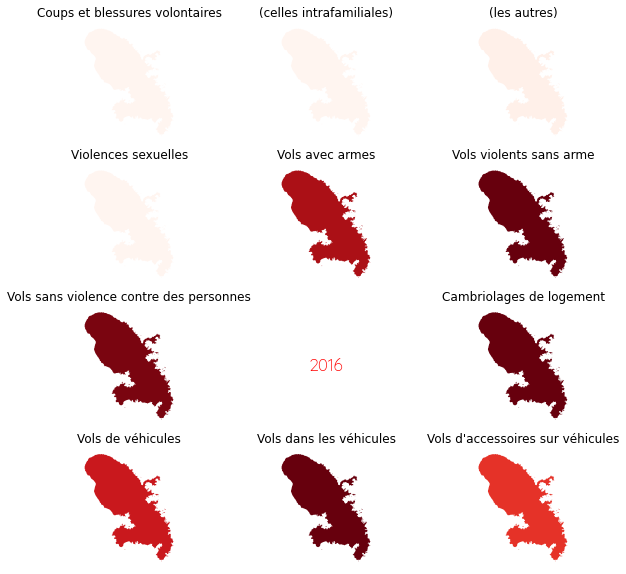

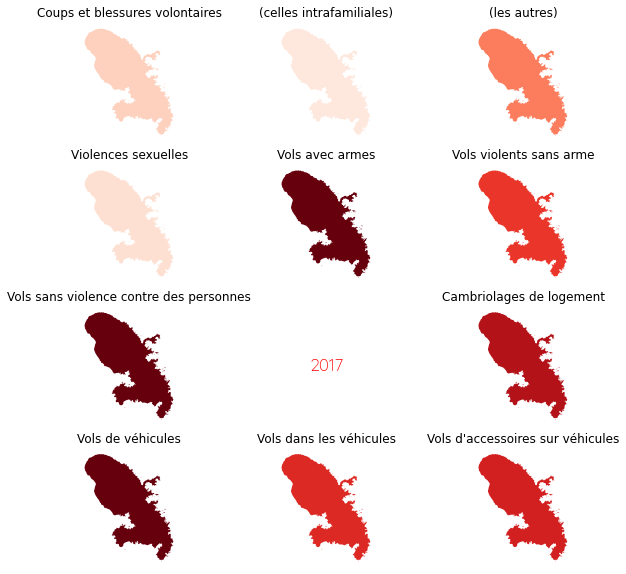

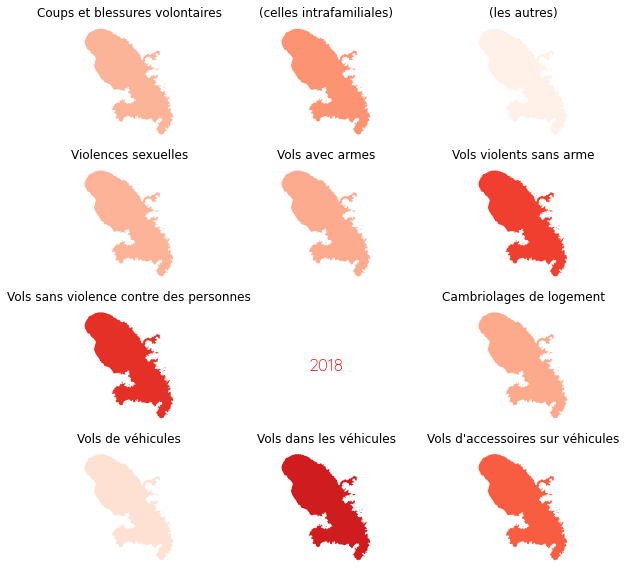

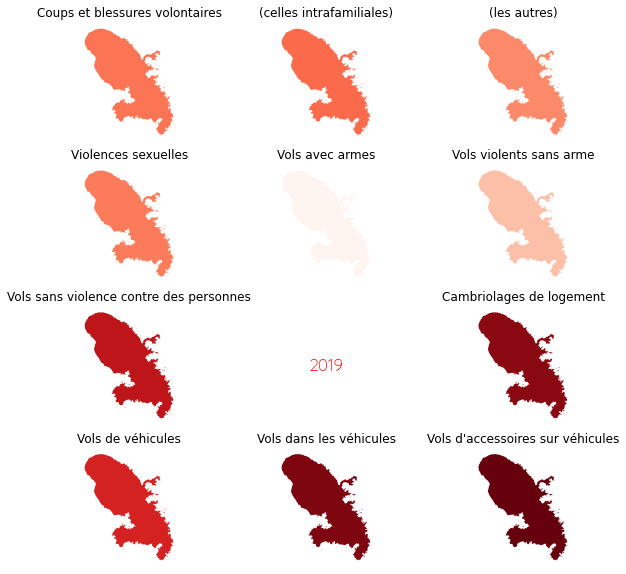

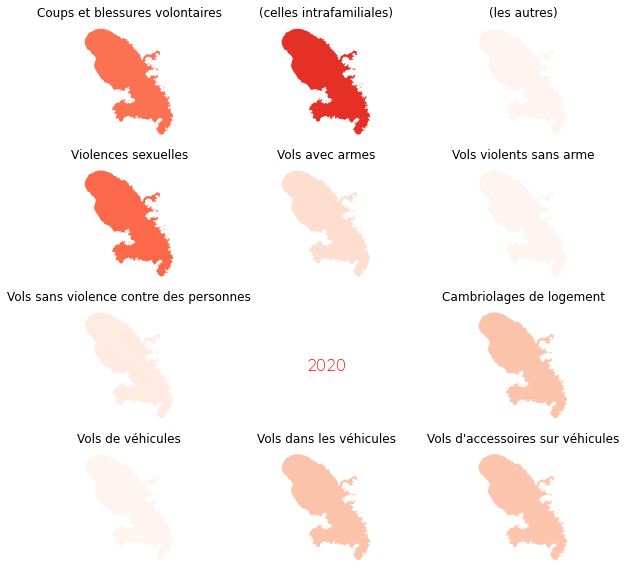

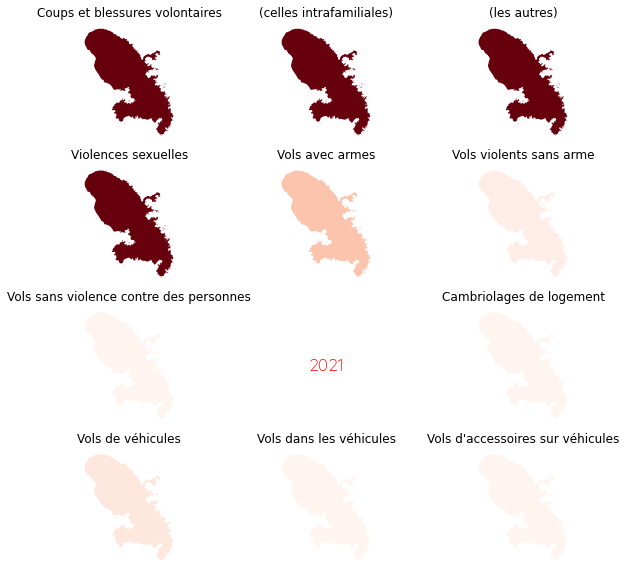

In [6]:
pos = 0
for annee in range(16, 22):
    ordered_classe = df_mq['classe'].unique() # no order yet
    N_COLS = 3
    N_ROWS = 4
    f, axes = plt.subplots(figsize=(10, 10), ncols=N_COLS, nrows=N_ROWS)
    x, y = 0, 0
    reds = matplotlib.cm.get_cmap('Reds')
    axes[2][1].text(0.5, 0.5, f'20{annee}', bbox={'facecolor':'white','alpha':1,'edgecolor':'none', 'pad':1}, color='red', ha='center', va='center', fontsize="xx-large", fontproperties="Quicksand Light")
    for i, classe in enumerate(ordered_classe):
        classe_output = classe
        if classe == 'Coups et blessures volontaires intrafamiliaux':
            classe_output = "(celles intrafamiliales)"
        elif classe == 'Autres coups et blessures volontaires':
            classe_output = "(les autres)"
        _ = axes[x][y].set_title(classe_output)
        vals = list(df_mq.loc[(df_mq.annee == annee) & (df_mq.classe == classe)][['tauxpourmille', 'taux_min', 'taux_max']].values)[0]
        norm = matplotlib.colors.Normalize(vmin=vals[1], vmax=vals[2])
        gdf_mq.plot(ax=axes[x][y], color=reds(norm(vals[0])))
        y += 1
        if x == 2 and y == 1:
            y += 1
        if y >= N_COLS:
            y = 0
            x += 1

    for i in range(N_ROWS):
        for j in range(N_COLS):
            axes[i][j].axis('off')
    plt.savefig(f'output-tmp/2022-11-11-{annee}.png', facecolor='white')
    #plt.savefig(f'output-tmp/2022-11-11-{pos}.png', facecolor='white')
    pos += 1

In [7]:
# need ImageMagick
!convert -delay 200 -loop 0 output-tmp/2022-11-11-*.png output/2022-11-11.gif

In [8]:
# check local fonts
import matplotlib.font_manager
print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
print(", ".join(sorted(list(set([f.name for f in matplotlib.font_manager.fontManager.ttflist])))))

['/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/noto/NotoSansMono-Bold.ttf', '/usr/share/fonts/truetype/freefont/FreeSerif.ttf', '/usr/share/fonts/opentype/urw-base35/D050000L.otf', '/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf', '/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/opentype/urw-base35/NimbusSansNarrow-BoldOblique.otf', '/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf', '/usr/share/fonts/opentype/cantarell/Cantarell-ExtraBold.otf', '/usr/share/fonts/opentype/font-awesome/FontAwesome.otf', '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf', '/usr/share/fonts/opentype/urw-base35/URWBookm